In [1]:
%matplotlib inline

In [2]:
import os, csv, glob, json
import scipy, matplotlib
import pylab as plt
import numpy as np
from matplotlib import gridspec
from collections import defaultdict
import sys
toplevelpath = os.path.realpath(os.path.pardir)
curdir = os.path.abspath(os.path.curdir)
sys.path.append(curdir)
sys.path.append(os.path.join(curdir,'FUImaging'))

from regnmf import ImageAnalysisComponents as ia

In [3]:
fig_dim = (7.48,9.4)
global_fs= 8 

layout = {   'axes.labelsize': 8,
             'axes.linewidth': .5, 
             'xtick.major.size': 2,     # major tick size in points
             'xtick.minor.size': 1,     # minor tick size in points
             'xtick.labelsize': 7,       # fontsize of the tick labels
             'xtick.major.pad': 2,  
             
             'ytick.major.size': 2,      # major tick size in points
             'ytick.minor.size': 1,     # minor tick size in points
             'ytick.labelsize':7,       # fontsize of the tick labels
             'ytick.major.pad': 2,
             
             'mathtext.default' : 'regular' 
             }

import matplotlib as mpl
for k, v in layout.items():
    mpl.rcParams[k] = v 

In [4]:
stim_cut = (3,5) 

basepath = os.path.realpath(os.path.join(os.path.pardir, 'glomcentric_data'))
datadict_path = os.path.join(basepath, 'DataDicts')
savepath = os.path.realpath(os.path.join('.', 'MOBFigS1'))

cas2name = {l[0]:l[1] for l in csv.reader(open(os.path.join(datadict_path,'Name2MomCas.tab')),  delimiter='\t')}
cas2name['7440-37-1'] = 'Argon (Control)'

## Helper functions

In [5]:
def no_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])
  
# timecourses plotter
rep_param = defaultdict(lambda: {'linewidth':1, 'ls':'--', 'color':'0.8'})
rep_param.update({0:{'linewidth':0.6, 'ls':'--' , 'color':'k','marker':'.', 'ms':2, 'dashes':(2,2)}, 
           1:{'linewidth':0.6, 'ls':'--', 'color':'0.4', 'marker':'.','ms':2, 'dashes':(2,2), 'mec':'0.4'}})
def timeplot(ax, data, mode):
    xtime = np.arange(5)
    stimpos_dict = defaultdict(list)
    for lab_ind, lab in enumerate(data.label_stimuli):
        stimpos_dict[lab].append(lab_ind)
    for stim_num, stim in enumerate(stimpos_dict.keys()):
        for stimrep, stimpos in enumerate(stimpos_dict[stim]):
            xpoints = xtime + stim_num*5
            # only 2 repitions
            if stimrep >1:
                break          
            
            if stim_num == 0: # plot with legend
                ax.plot(xpoints, data.trial_shaped()[stimpos,:,mode], label='trial %d'%(stimrep+1), **rep_param[stimrep])
            else:
                ax.plot(xpoints, data.trial_shaped()[stimpos,:,mode],**rep_param[stimrep])

    myxticks = np.hstack([xtime+i*5 for i in range(len(stimpos_dict))])
    yticks = [0,1,2]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.yaxis.set_tick_params(labelsize=7)
    #ax.set_xticks(myxticks, minor=True)
    ax.set_xticks(range(0, len(stimpos_dict)*5, 5))
    ax.set_xticklabels([])
    ax.set_xlim((0,len(stimpos_dict)*5))
    ax.yaxis.set_ticks_position('right')

def base_overlay(ax, bg, toplot, alpha_thres=0.3):
    fig_temp = plt.figure()
    ax_temp = fig_temp.add_subplot(111)
    toplot_rgba = plt.cm.jet(toplot) #cmap_bases((toplot+1)/2.)
    alpha =0.8*np.ones(toplot.shape)
    alpha[np.abs(toplot)<alpha_thres]=0
    toplot_rgba[:,:,3]=alpha
    ax_temp.imshow(bg, interpolation='none', cmap=plt.cm.bone, extent=[-0.5,168-0.5,128-0.5,-0.5], vmin=-0.1)
    ax_temp.imshow(toplot_rgba, interpolation='none')
    ax_temp.set_axis_off()
    no_ticks(ax_temp)
    fig_temp.savefig(os.path.join(savepath,'mytemp.png'), bbox_inches='tight', pad_inches=0)
    plt.close(fig_temp)
    im = plt.imread(os.path.join(savepath,'mytemp.png'))
    ax.imshow(im, interpolation='nearest')
    no_ticks(ax)
    
def condense_list_dict(dic, reducefct=np.mean):
    ''' apply reducefct to every value of dictionary'''
    reduced_dict = {}
    for k, v in dic.items():
        reduced_dict[k] = reducefct(v)
    return reduced_dict

### Get the data

In [6]:
animal = '120125'#'110224'
method =  'nnmf_200_sm2_convex_negTimelowSP_sp*_ios_meas'

filt_data_file = os.path.join(basepath, 'MOBconverted', animal, 'ios_meas')
bg_file = os.path.join(basepath, 'MOBconverted', animal, 'bg.png')
#green_file = os.path.join(basepath, 'MOBconverted', animal, 'green.png')
mf_filename = glob.glob(os.path.join(basepath, 'MOBdecomposed', animal, method+'.npy'))
assert len(mf_filename)==1
mf_filename = mf_filename[0].split('.')[0]

In [7]:
filt_data = ia.TimeSeries()
filt_data.load(filt_data_file)
filt_data = ia.TrialMean()(ia.CutOut(stim_cut)(filt_data))
filt_data.label_stimuli = [i.split('_')[0] for i in filt_data.label_stimuli]

mf = ia.TimeSeries()
mf.load(mf_filename)
mf.label_stimuli = [i.split('_')[0] for i in mf.label_stimuli]


bg = plt.imread(bg_file)
#green = plt.imread(green_file)

In [8]:
average_function = np.median
methodspec =  'nnmf_200_sm2_convex_negTimelowSP_sp*_ios_measnormed'
mor182specIOS_file = os.path.join(basepath, 'DataDicts', 'MOR18-2spec.json')
mor182specIOS = json.load(open(mor182specIOS_file))

#Select only pure odors. Hack! All mixtures contain either E or A 
pure_odors = [o for o in mor182specIOS[methodspec].keys() if (len(o.split('_'))<2) and ('E' not in o) and ('A' not in o) and  ('B' not in o) ] 
pure_odor_resp = [average_function(mor182specIOS[methodspec][o]) for o in pure_odors]
odors_sorted = [pure_odors[i] for i in np.argsort(pure_odor_resp)]
spec = [average_function(mor182specIOS[methodspec][i]) for i in odors_sorted]

In [9]:
test =scipy.stats.ttest_ind # scipy.stats.mannwhitneyu#

p_val_argon = np.array([test(mor182specIOS[methodspec]['7440-37-1'], mor182specIOS[methodspec][i]) for i in odors_sorted])[:,1]
p_val_argon[np.isnan(p_val_argon)] = 1
p_val_argon[p_val_argon>0.05] = 1

/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sam/anaconda3/envs/glomcentric_code/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
mean_maps = ia.SingleSampleResponse()(filt_data)

In [11]:
mycas = [
'141-78-6', '105-37-3',         
'79-20-9', '554-12-1',

'109-60-4', '106-36-5',
'123-86-4',
'2408-20-0',
'78-98-8', '540-42-1']

In [12]:
for ix, cas in enumerate(mean_maps.label_stimuli):
    print(cas, cas2name[cas])

140-88-5 Ethyl acrylate
Anisole - GEO Anisole - GEO
96-04-8 2,3-Heptanedione
470-67-7 Cineole
106-36-5 Propyl propionate
123-63-7 Paraldehyde
591-87-7 Allyl acetate
35466-83-2 Allyl methyl carbonate
110-19-0 Isobutyl acetate
7452-79-1 Ethyl 2-methylbutyrate
3848-24-6 2,3-Hexanedione
MP - GEO MP - GEO
600-14-6 2,3-Pentanedione
542-55-2 Isobutyl formate
78-98-8 Pyruvaldehyde
2M2P - GEO 2M2P - GEO
108-21-4 Isopropyl acetate
123-86-4 Butyl acetate
95-92-1  Diethyl oxalate
19788-49-9 Ethyl 2-mercaptopropionate
628-63-7 Pentyl acetate
89-82-7 (R)-(+)-Pulegone
540-42-1 Isobutyl propionate
590-86-3 3-Methylbutyraldehyde
75-07-0 Acetaldehyde
7493-71-2 Allyl tiglate
6622-76-0 Methyl tiglate
589-38-8 3-Hexanone
2497-18-9 trans-2-Hexenyl acetate
109-60-4 Propyl acetate
105-58-8 Diethyl carbonate
123-66-0 Ethyl hexanoate
141-78-6 Ethyl acetate
EA - GEO EA - GEO
25680-58-4  2-Ethyl-3-methoxypyrazine
93-58-3 Methyl benzoate
100-66-3 Anisole
107-87-9 2-Pentanone
431-03-8 2,3-Butanedione
106-23-0 (±)-C

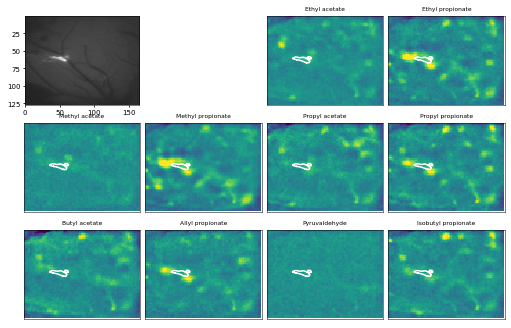

In [13]:
fig  = plt.figure(figsize=fig_dim)

# plot image maps
gs = gridspec.GridSpec(6,4)
gs.update(**{'left':0.05, 'right':0.95, 'top':0.97, 'bottom':0.05, 'wspace':0.01})
#fig.text(0.185, 0.97, '(b)', ha='right', va='bottom', fontsize=8, fontweight='bold')
for ix, cas in enumerate(mycas): #mean_maps.label_stimuli):
    toplot = mean_maps.shaped2D()[mean_maps.label_stimuli.index(cas)]
    ax = fig.add_subplot(gs[ix+2])
    mymax = np.max(toplot)
    #toplot /= mymax
    #toplot[toplot<0] = 0
    #alpha = 0.75*np.ones(toplot.shape)
    #alpha[toplot<0.3] = 0
    #toplot = plt.cm.jet(toplot)
    #toplot[:,:,3] = alpha
    
    im_h = ax.imshow(toplot, interpolation='none', vmin=-1.5, vmax=1.5)
    cont = ax.contour(bg, [0.4], extent=[0,84,0.5,64], colors=['w'])
    #cont = ax.contour(green, [0.4], extent=[0,164,0.5,128], colors=['k'])
    ax.set_title(cas2name[cas], size=6)
    ax.set_xticks([])
    ax.set_yticks([])

#ax = fig.add_subplot(gs[0])   
#im_h = ax.imshow(green, interpolation='none', cmap=plt.cm.bone)
ax = fig.add_subplot(gs[0])   
im_h = ax.imshow(bg, interpolation='none', extent=[0,164,128,0.5], cmap=plt.cm.binary_r, vmin=-0.1)
# add colorbar
'''
axbar = fig.add_axes([0.77, bottom_line1, 0.01, 0.97-bottom_line1])
cbar = fig.colorbar(im_h, axbar)
cbar.set_ticks([-3,0,3])
cbar.set_label(r'$-\Delta R/R$'+ u' [\u2030]', size=global_fs, labelpad=-2)
axbar.yaxis.set_tick_params(labelsize=global_fs, pad=2)
'''

if not os.path.isdir(os.path.join(os.pardir, savepath)):
    os.makedirs(os.path.join(os.pardir, savepath))
fig.savefig(os.path.join(savepath,'test.pdf'))
plt.show()

## Plot the data

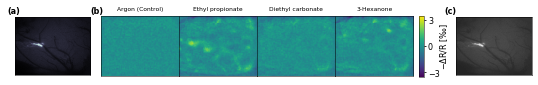

In [14]:
fig  = plt.figure(figsize=fig_dim)
cas2plot =['7440-37-1', '105-37-3', '105-58-8', '589-38-8'] #Picked randomly as most don't exist ['7440-37-1', '105-37-3', '105-54-4', '5837-78-5'] #'141-78-6',

bottom_line1 = 0.88
# plot green image
gs = gridspec.GridSpec(1,1)
gs.update(**{'left':0.02, 'right':0.16, 'top':0.97, 'bottom':bottom_line1})
fig.text(0.03, 0.97, '(a)', ha='right', va='bottom', fontsize=8, fontweight='bold')
ax = fig.add_subplot(gs[0])
im_h = ax.imshow(bg, interpolation='none', cmap=plt.cm.bone)
ax.set_xticks([])
ax.set_yticks([])

# plot image maps
gs = gridspec.GridSpec(1,4)
gs.update(**{'left':0.18, 'right':0.76, 'top':0.97, 'bottom':bottom_line1, 'wspace':0.})
fig.text(0.185, 0.97, '(b)', ha='right', va='bottom', fontsize=8, fontweight='bold')
for ix, cas in enumerate(cas2plot):
    toplot = filt_data.shaped2D()[filt_data.label_stimuli.index(cas)]
    ax = fig.add_subplot(gs[0,ix])
    im_h = ax.imshow(toplot, interpolation='none', vmin=-3.5, vmax=3.5)
    ax.set_title(cas2name[cas], size=6)
    ax.set_xticks([])
    ax.set_yticks([])
# add colorbar
axbar = fig.add_axes([0.77, bottom_line1, 0.01, 0.97-bottom_line1])
cbar = fig.colorbar(im_h, axbar)
cbar.set_ticks([-3,0,3])
cbar.set_label(r'$-\Delta R/R$'+ u' [\u2030]', size=global_fs, labelpad=-2)
axbar.yaxis.set_tick_params(labelsize=global_fs, pad=2)
    
    
# plot gfp image
gs = gridspec.GridSpec(1,1)
gs.update(**{'left':0.84, 'right':0.98, 'top':0.97, 'bottom':bottom_line1})
fig.text(0.84, 0.97, '(c)', ha='right', va='bottom', fontsize=8, fontweight='bold')
ax = fig.add_subplot(gs[0])
im_h = ax.imshow(bg, interpolation='none', cmap=plt.cm.binary_r, vmin=-0.1)
no_ticks(ax)

#plt.show()

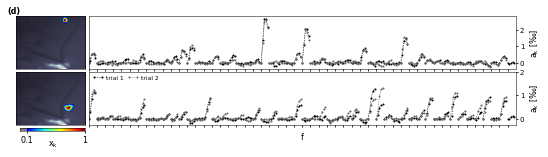

In [18]:
fig  = plt.figure(figsize=fig_dim)

components2plot = [4,22]

gs = gridspec.GridSpec(2,2, width_ratios=[1,6])
gs.update(**{'left':0.02, 'right':0.95, 'top':0.86, 'bottom':0.7, 'wspace':0.01, 'hspace':0.05})
fig.text(0.03, 0.861, '(d)', ha='right', va='bottom', fontsize=8, fontweight='bold')

for ix, comp in enumerate(components2plot):
    ax = fig.add_subplot(gs[ix,0])
    base_overlay(ax, bg, mf.base.shaped2D()[comp], alpha_thres=0.1)
    
    ax = fig.add_subplot(gs[ix,1])
    timeplot(ax, mf, comp)
    ax.set_ylabel('$a_k$' + u' [\u2030]', size=global_fs, labelpad=4)
    ax.yaxis.set_tick_params(pad=2)
    ax.yaxis.set_label_position('right')
ax.set_xlabel('f')
    
# make legend
ax.legend(loc = 'upper left', numpoints=2, ncol=2, prop={'size':6}, columnspacing=0.5, 
          handlelength=2, handletextpad=0.3, frameon=False, borderaxespad=0.2)


# colormap
jetcmap = plt.cm.get_cmap("jet", 20) #generate a jet map with 20 values
jet_vals = jetcmap(np.arange(20)) #extract those values as an array
jet_vals[0] = [0.5, 0.5, 0.5, 1] #change the first value
jet_vals[1] = [0.5, 0.5, 0.5, 1] #change the first value
newcmap = mpl.colors.LinearSegmentedColormap.from_list("newjet", jet_vals)

# colorbar
axbar = fig.add_subplot(position=[0.03,0.69,0.12,0.005])
colordata = np.linspace(0,1,101)
colordata[0:10]=0
axbar.imshow(colordata[:,np.newaxis].T, cmap=newcmap, aspect='auto')
axbar.set_yticks([])
axbar.xaxis.set_tick_params(labelsize=global_fs, pad=2)
axbar.set_xticks([10,101])
axbar.set_xticklabels([0.1,1])
axbar.set_xlabel('$x_{k}$', size=global_fs, labelpad=-5)

plt.show()

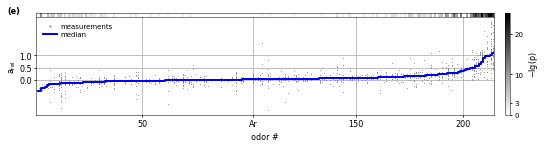

In [19]:
fig  = plt.figure(figsize=fig_dim)

gs = matplotlib.gridspec.GridSpec(2,1, top=0.66, bottom=0.51, left=0.06, right=0.91, height_ratios=[1,25], hspace=0)
gsbar = matplotlib.gridspec.GridSpec(1,1, top=0.66, bottom=0.51, left=0.93, right=0.94)

num_odors = len(spec)

ax = fig.add_subplot(gs[0])
fig.text(0.03, 0.657, '(e)', ha='right', va='bottom', fontsize=8, fontweight='bold')
im = ax.imshow(-np.log10(p_val_argon).reshape((1,-1)), plt.cm.binary, interpolation='none', aspect='auto', vmax=25)
ax.set_xlim((-0.5, num_odors-0.5))
ax.set_xticks([])
ax.set_yticks([])
#ax.set_ylabel('p Argon', rotation='0', ha='right', size=8)

ax = fig.add_subplot(gs[1])
# individual measurements
for ix, mol in enumerate(odors_sorted):
    points = ax.plot(ix, np.array(mor182specIOS[methodspec][mol]).reshape((1,-1)), '.', 
                     ms=2, mec='none', mfc='0.5')

#average activation
stairs = ax.step(np.arange(num_odors+1)+0.5, [spec[0]]+spec, 'b', lw=2)

#decorate
ax.set_xticks([49,odors_sorted.index('7440-37-1'),149,199])
ax.set_xticklabels(['50','Ar','150','200'], size=8)
#ax.set_xticks([odors_sorted.index(i) for i in ['7440-37-1']], minor=True)
#ax.set_xticklabels(['Ar'], minor=True, size=8, rotation='45', ha='right')

ax.set_xlim((-0.5, num_odors-0.5))
ax.set_yticks([0,0.5,1])
ax.yaxis.set_tick_params(labelsize=8)
ax.grid()
ax.set_ylabel('$a_{rel}$', size=8, labelpad=1)
ax.set_xlabel('odor #', size=8)
ax.legend((points[0], stairs[0]), ('measurements', 'median'), loc='upper left', frameon=False,
          fontsize=7, numpoints=1, handletextpad=0.5, labelspacing=0.3, markerscale=2)

cbar = fig.add_subplot(gsbar[0])
cbar = fig.colorbar(im, cax=cbar)
cbar.set_label('$-{lg}(p)$')
cbar.set_ticks([0,3,10,20])

fig.savefig(os.path.join(savepath, 'Fig1.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
import math
for i in range(len(spec)):
    print(cas2name[odors_sorted[i]], '%.2f'%spec[i], '%.2f'%(4*np.sqrt(np.abs(spec[i]/math.pi))), '%.3f'%p_val_argon[i])
